# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# The number of rows and columns of the demographics data
azdias.shape

(891221, 85)

In [4]:
# The number of rows and columns for the feature attributes summary
feat_info.shape

(85, 4)

In [5]:
#The first 6 rows of the demographics data
azdias.head(n=6)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [6]:
#The data types of the demographics data
azdias.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
          

In [7]:
#The description of the demographics data
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
# the feature attributes summary
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
#Make a copy of feat_info dataframe to prevent any future unwanted change
azdias_copy = azdias.copy()
feat_info_copy = feat_info.copy()

In [10]:
# print the Number of naturally missing data
print('Number of naturally missing data: {:,}'.format(azdias_copy.isnull().sum().sum()))

Number of naturally missing data: 4,896,838


In [11]:
for index in range(feat_info_copy.shape[0]):
    col=azdias_copy.columns[index]
    null_list= feat_info_copy.iloc[index,3]
    null_list= null_list.strip('[]').split(',')
    
    if null_list != ['']:
        for null_value in null_list:
            if null_value!='X' and null_value!='XX' and null_value!='':
                null_value= int(null_value)
            else:
                null_value=null_value
            
            azdias_copy.loc[azdias_copy[col]==null_value,col]=np.nan                             
            

In [12]:
# print the Number of data takes on a missing or unknown codes
print('Number of data takes on a missing or unknown codes: {:,}'.format(azdias_copy.isnull().sum().sum()))

Number of data takes on a missing or unknown codes: 8,373,929


In [13]:
#get unique values to check if the null values are converted to NaN
azdias_copy.ARBEIT.unique()

array([ nan,   3.,   2.,   4.,   1.,   5.])

In [14]:
#display 5 records to check if the null values are converted to NaN
azdias_copy.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_col_percent= ((azdias_copy.isnull().sum(axis=0))/len(azdias_copy))*100
missing_data_col_percent.sort_values(inplace=True)
missing_data_col_percent

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

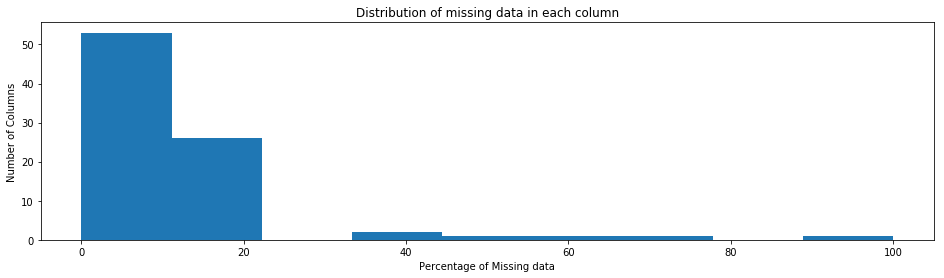

In [16]:
#Plot the distribution of missing data in each column
plt.figure(figsize=(16,4))
plt.title('Distribution of missing data in each column')
plt.hist(missing_data_col_percent, bins=np.linspace(0,100,10))
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing data')
plt.show()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#divide data into 2 subset based on the quantity of missing data 

Low_missing_data_col_percent = missing_data_col_percent[missing_data_col_percent <= 30]
High_missing_data_col_percent = missing_data_col_percent[missing_data_col_percent > 30]

In [18]:
#print the information
print('The Number of Low_missing_value columns is:', Low_missing_data_col_percent.count(),'\n')
print('The Number of High_missing_value columns is:', High_missing_data_col_percent.count(),'\n')
print('The Low_missing_value columns are:\n', Low_missing_data_col_percent.index.tolist(),'\n')
print('The High_missing_value columns are:\n', High_missing_data_col_percent.index.tolist())

The Number of Low_missing_value columns is: 79 

The Number of High_missing_value columns is: 6 

The Low_missing_value columns are:
 ['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_RAT', 'SEMIO_KULT', 'SEMIO_ERL', 'SEMIO_LUST', 'SEMIO_VERT', 'SEMIO_MAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_FAM', 'FINANZ_VORSORGER', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'FINANZTYP', 'ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB', 'LP_STATUS_FEIN', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S', 'CJT_GESAMTTYP', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_TITEL', 'SOHO_KZ', 'ANZ_PERSONEN', 'KONSUMNAEHE', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'OST_WEST_KZ', 'WOHNLAGE', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP_RASTER', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'LP_LEBENSPHASE_GROB', 'ANZ_HH_TITEL', 'ORTSGR_KLS9', 'ARBEIT', 'RELAT_AB', 'LP_LEBENSPHASE_FEIN', 'CAM

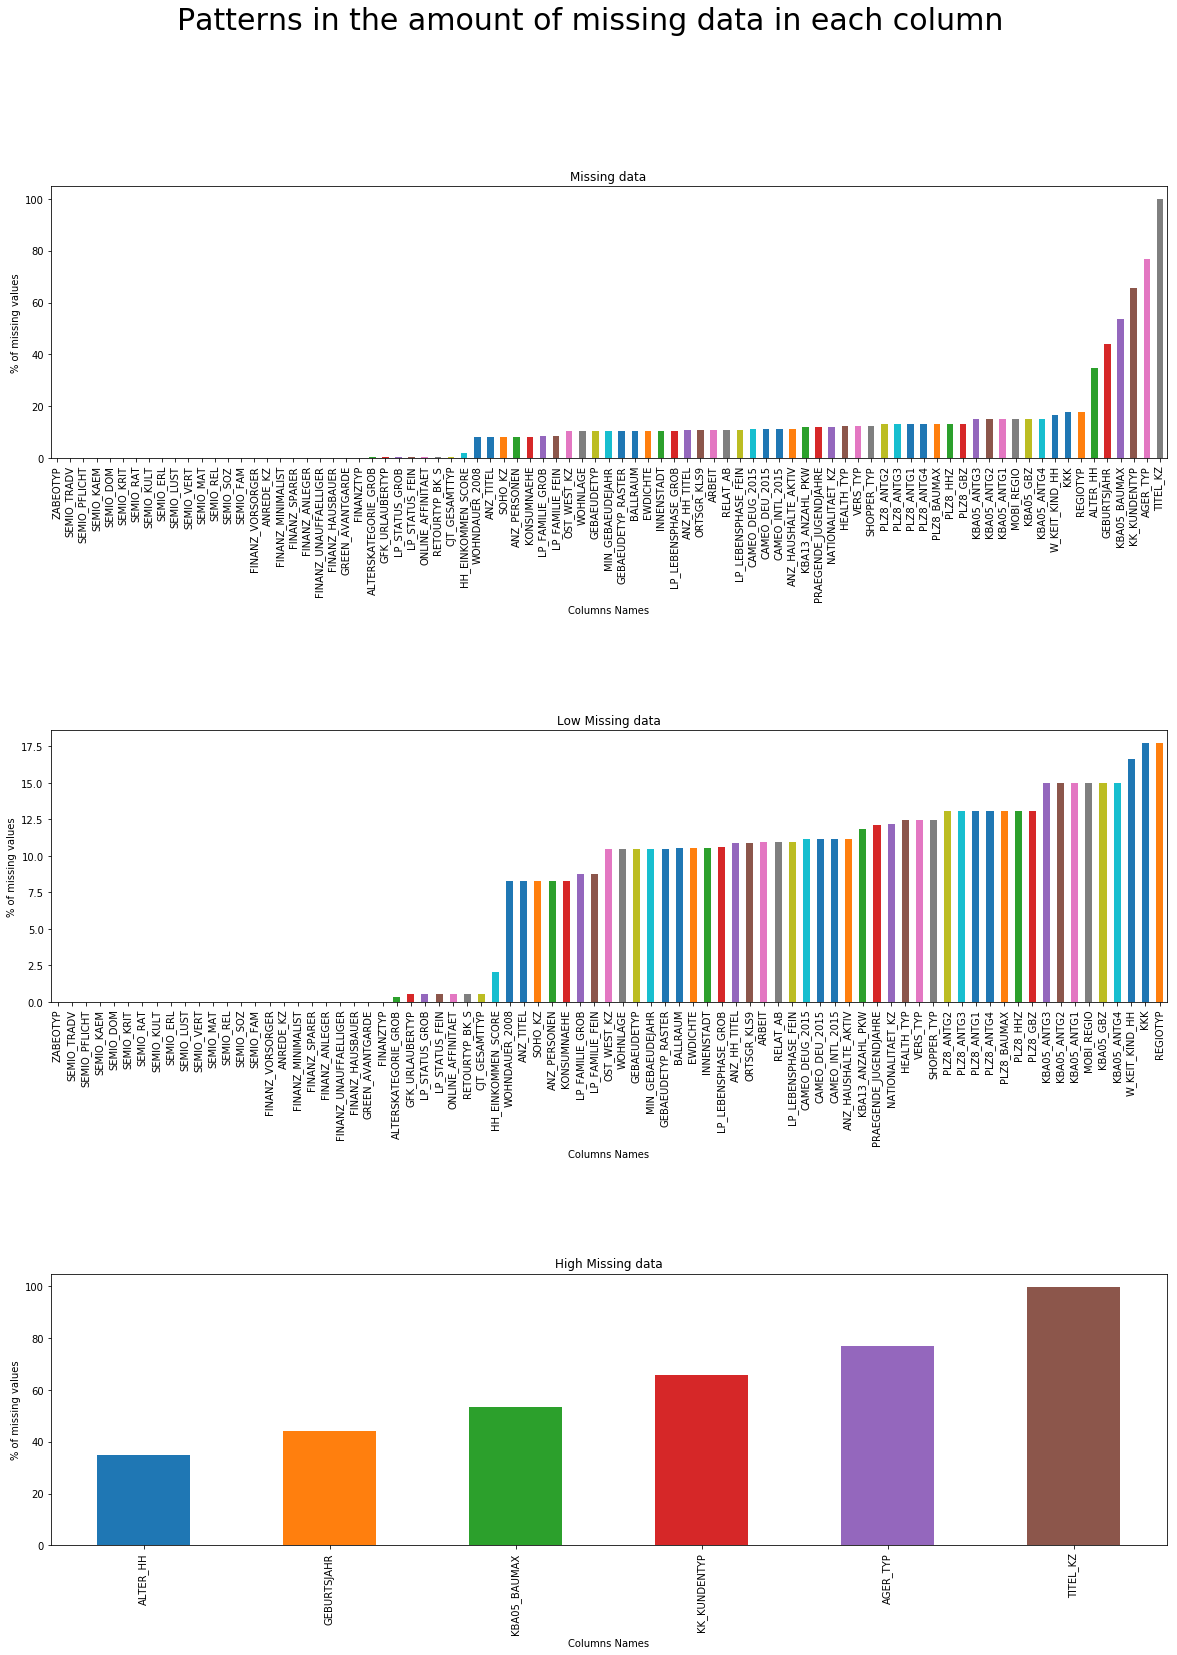

In [19]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(20, 25))
plt.suptitle('Patterns in the amount of missing data in each column', fontsize=30)
plt.subplots_adjust(hspace = 1, wspace=.3)
plt.subplot(311)
missing_data_col_percent.plot.bar()
plt.title('Missing data')
plt.xlabel('Columns Names')
plt.ylabel('% of missing values')
plt.subplot(312)
Low_missing_data_col_percent.plot.bar()
plt.title('Low Missing data')
plt.xlabel('Columns Names')
plt.ylabel('% of missing values')
plt.subplot(313)
High_missing_data_col_percent.plot.bar()
plt.title('High Missing data')
plt.xlabel('Columns Names')
plt.ylabel('% of missing values')
plt.show()


In [20]:
missing_data_col_percent_values= missing_data_col_percent.value_counts()
missing_data_col_percent_values

0.000000     24
13.073637     7
0.544646      6
14.959701     6
10.451729     4
8.247000      4
10.518154     3
11.147852     3
12.476816     3
10.926022     2
8.728699      2
17.735668     2
16.605084     1
12.136608     1
53.468668     1
2.058749      1
10.914689     1
12.153551     1
10.452514     1
10.954859     1
0.323264      1
99.757636     1
10.611509     1
10.884842     1
34.813699     1
76.955435     1
44.020282     1
65.596749     1
8.299737      1
11.176913     1
11.871354     1
dtype: int64

In [21]:
Shared_missing_data_col_values= missing_data_col_percent_values.index[1:12]
Shared_missing_data_col_values= Shared_missing_data_col_values.sort_values()
Shared_missing_data_col_values

Float64Index([   0.5446460529992,  8.247000463409188,  8.728699166648902,
              10.451728583594866, 10.518154307405233,  10.92602171627464,
              11.147852216229195, 12.476815514894735, 13.073637178657146,
              14.959701353536328,  17.73566825736826],
             dtype='float64')

In [22]:
missing_data_col_percent_sorted= missing_data_col_percent.sort_values()
missing_data_col_percent_sorted_index= missing_data_col_percent_sorted.index
missing_data_col_percent_sorted_index
missing_data_col_percent_sorted

ZABEOTYP                  0.000000
FINANZTYP                 0.000000
GREEN_AVANTGARDE          0.000000
FINANZ_HAUSBAUER          0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_SPARER             0.000000
FINANZ_MINIMALIST         0.000000
ANREDE_KZ                 0.000000
FINANZ_VORSORGER          0.000000
SEMIO_FAM                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_REL                 0.000000
FINANZ_ANLEGER            0.000000
SEMIO_VERT                0.000000
SEMIO_LUST                0.000000
SEMIO_ERL                 0.000000
SEMIO_KULT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KRIT                0.000000
SEMIO_DOM                 0.000000
SEMIO_KAEM                0.000000
SEMIO_PFLICHT             0.000000
SEMIO_TRADV               0.000000
SEMIO_MAT                 0.000000
ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
RETOURTYP_BK_S            0.544646
ONLINE_AFFINITAET         0.544646
LP_STATUS_GROB      

In [23]:
for value in Shared_missing_data_col_values:
    col_names=(missing_data_col_percent_sorted[missing_data_col_percent_sorted==value].index.tolist()) 
    print('There\'re ({}) features with ({}) percent of missing data: \n'.format(len(col_names), value))
    print('{}\n'.format(col_names))
    print('{}\n{}\n\n'.format(feat_info_copy.loc[feat_info_copy['attribute'].isin(col_names)],'-'*120))

There're (6) features with (0.5446460529992) percent of missing data: 

['CJT_GESAMTTYP', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN']

            attribute information_level         type missing_or_unknown
3       CJT_GESAMTTYP            person  categorical                [0]
12    GFK_URLAUBERTYP            person  categorical                 []
19     LP_STATUS_FEIN            person  categorical                [0]
20     LP_STATUS_GROB            person  categorical                [0]
23     RETOURTYP_BK_S            person      ordinal                [0]
72  ONLINE_AFFINITAET        region_rr1      ordinal                 []
------------------------------------------------------------------------------------------------------------------------


There're (4) features with (8.247000463409188) percent of missing data: 

['WOHNDAUER_2008', 'ANZ_TITEL', 'SOHO_KZ', 'ANZ_PERSONEN']

         attribute information_level         type miss

In [24]:
#remove high missing features from azdias dataframe
azdias_copy.drop(High_missing_data_col_percent.index.tolist(), axis=1, inplace=True)

In [25]:
#check if the columns are removed
azdias_copy.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [26]:
#remove high missing features from feat_info dataframe
feat_info_copy = feat_info_copy.set_index('attribute')
feat_info_copy= feat_info_copy.drop(High_missing_data_col_percent.index.tolist(), axis=0)

In [27]:
#check if the features are removed
feat_info_copy

,information_level,type,missing_or_unknown
attribute,,,
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- The majority of the columns are missing less than 200,000 data. So, columns with more than 200,000 data were considered as <font color=darkred> outliers.</font> 
- Hence, 6 columns were removed: <font color=darkred>['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'] </font> 
<br>  

#### <font color=blue>There are 11 missing value patterns:</font>

##### <font color=darkblue>Pattern (1)</font>
***There're (6) features with (0.54) percent of missing data:***
1. 'CJT_GESAMTTYP'
2. 'RETOURTYP_BK_S'
3. 'ONLINE_AFFINITAET'
4. 'LP_STATUS_GROB'
5. 'GFK_URLAUBERTYP'
6. 'LP_STATUS_FEIN'
<br> 

***Common characteristics of the features:*** 
- 'CJT_GESAMTTYP', 'RETOURTYP_BK_S', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP', and 'LP_STATUS_FEIN' are <font color=darkgreen>Person-level features.</font> 
- 'LP_STATUS_FEIN' and 'LP_STATUS_GROB' <font color=darkgreen> contain the same information about Social status, but they differ in the scale type either fine scale or rough scale.</font> 


##### <font color=darkblue>Pattern (2)</font>
***There're (4) features with (8.24) percent of missing data:***
1. 'WOHNDAUER_2008'
2. 'ANZ_TITEL'
3. 'SOHO_KZ'
4. 'ANZ_PERSONEN'
<br>

***Common characteristics of the features:*** 
- 'WOHNDAUER_2008', 'ANZ_TITEL', and 'ANZ_PERSONEN' are <font color=darkgreen> Household-level features. </font>
- 'ANZ_TITEL' and 'ANZ_PERSONEN' are <font color=darkgreen> numeric features. </font>

##### <font color=darkblue>Pattern (3)</font>
***There're (2) features with (8.72) percent of missing data:*** 
1. 'LP_FAMILIE_FEIN'
2. 'LP_FAMILIE_GROB'
<br>

***Common characteristics of the features:***  
- 'LP_FAMILIE_FEIN' and 'LP_FAMILIE_GROB' are <font color=darkgreen> Person-level features. </font>
- 'LP_FAMILIE_FEIN' and 'LP_FAMILIE_GROB' are <font color=darkgreen> categorical features. </font> 
- 'LP_FAMILIE_FEIN' and 'LP_FAMILIE_GROB' <font color=darkgreen> hold the same information about the Family type, but they differ in the scale type either fine scale or rough scale.</font>

##### <font color=darkblue>Pattern (4)</font>
***There're (4) features with (10.45) percent of missing data:***
1. 'GEBAEUDETYP'
2. 'MIN_GEBAEUDEJAHR'
3. 'OST_WEST_KZ'
4. 'WOHNLAGE'
<br>

***Common characteristics of the features:*** 
- 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', and 'WOHNLAGE' are <font color=darkgreen>  Building-level features.</font>
- 'GEBAEUDETYP' and 'OST_WEST_KZ' are <font color=darkgreen> categorical features.</font>

##### <font color=darkblue>Pattern (5)</font>
***There're (3) features with (10.51) percent of missing data:*** 
1. 'BALLRAUM'
2. 'EWDICHTE'
3. 'INNENSTADT'
<br>

***Common characteristics of the features:***
- 'BALLRAUM', 'EWDICHTE', and 'INNENSTADT' are <font color=darkgreen> Postcode-level features.</font>
- 'BALLRAUM', 'EWDICHTE', and 'INNENSTADT' are <font color=darkgreen> ordinal features.</font>

##### <font color=darkblue>Pattern (6)</font>
***There're (2) features with (10.92) percent of missing data:*** 
1. 'RELAT_AB'
2. 'ARBEIT'
<br>

***Common characteristics of the features:*** 
- 'RELAT_AB' and 'ARBEIT' are <font color=darkgreen> Community-level features.</font> 
- 'RELAT_AB' and 'ARBEIT' are <font color=darkgreen> ordinal features.</font> 
- 'RELAT_AB' and 'ARBEIT' <font color=darkgreen> hold the same information about the share of unemployment in community.</font>

##### <font color=darkblue>Pattern (7)</font>
***There're (3) features with (11.14) percent of missing data:*** 
1. 'CAMEO_DEUG_2015'
2. 'CAMEO_DEU_2015'
3. 'CAMEO_INTL_2015'
<br>

***Common characteristics of the features:*** 
- 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', and  'CAMEO_INTL_2015' are <font color=darkgreen> RR4 micro-cell features.</font>
- 'CAMEO_DEUG_2015' and  'CAMEO_DEU_2015' are <font color=darkgreen> categorical features.</font> 
- 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', and 'CAMEO_INTL_2015' <font color=darkgreen> hold the same information about the German CAMEO: Wealth / Life Stage Typology. But they differ in the representative code either rough scale, detailed scale or mapped to international code.</font>

##### <font color=darkblue>Pattern (8)</font>
***There're (3) features with (12.47) percent of missing data:*** 
1. 'VERS_TYP'
2. 'SHOPPER_TYP'
3. 'HEALTH_TYP'
<br>

***Common characteristics of the features:***
- 'VERS_TYP', 'SHOPPER_TYP', and  'HEALTH_TYP' are <font color=darkgreen> Person-level features.</font> 
- 'SHOPPER_TYP', and  'HEALTH_TYP' are <font color=darkgreen> categorical features. </font> 


##### <font color=darkblue>Pattern (9)</font>
***There're (7) features with (13.07) percent of missing data:*** 
1. 'PLZ8_ANTG2'
2. 'PLZ8_ANTG3'
3. 'PLZ8_ANTG1'
4. 'PLZ8_ANTG4'
5. 'PLZ8_BAUMAX'
6. 'PLZ8_HHZ'
7. 'PLZ8_GBZ']
<br>

***Common characteristics of the features:*** 
- 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG1', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', and 'PLZ8_GBZ' are <font color=darkgreen> PLZ8 macro-cell features.</font> 
- 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG1', 'PLZ8_ANTG4', 'PLZ8_HHZ', and 'PLZ8_GBZ' are <font color=darkgreen>  ordinal features.</font> 

##### <font color=darkblue>Pattern (10)</font>
***There're (6) features with (14.95) percent of missing data:*** 
1. 'MOBI_REGIO'
2. 'KBA05_ANTG4'
3. 'KBA05_GBZ'
4. 'KBA05_ANTG1'
5. 'KBA05_ANTG2'
6. 'KBA05_ANTG3']
<br>

***Common characteristics of the features:*** 
- 'KBA05_ANTG4', 'KBA05_GBZ', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3' are <font color=darkgreen> RR3 micro-cell features.</font>
- 'MOBI_REGIO', 'KBA05_ANTG4', 'KBA05_GBZ', 'KBA05_ANTG1', 'KBA05_ANTG2',  and 'KBA05_ANTG3' are <font color=darkgreen> ordinal features.</font>

##### <font color=darkblue>Pattern (11)</font>
***There're (2) features with (17.73) percent of missing data:*** 
1. 'KKK'
2. 'REGIOTYP'
<br>

***Common characteristics of the features:*** 
- 'KKK' and 'REGIOTYP' are <font color=darkgreen> RR1 neighborhood features.</font>
- 'KKK' and 'REGIOTYP' are <font color=darkgreen> ordinal features. </font>



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
missing_rows= azdias_copy.isnull().sum(axis=1)
missing_rows

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [29]:
missing_rows.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

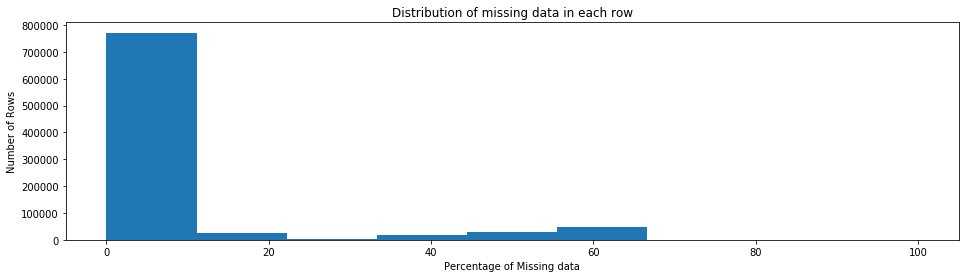

In [30]:
#Plot the distribution of missing data in each row
plt.figure(figsize=(16,4))
plt.title('Distribution of missing data in each row')
plt.hist(missing_rows / len(azdias_copy.columns) * 100, bins=np.linspace(0,100,10))
plt.ylabel('Number of Rows')
plt.xlabel('Percentage of Missing data')
plt.show()

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

Low_missing_data_row= missing_rows[missing_rows<=5]
High_missing_data_row= missing_rows[missing_rows>5]


In [32]:
Low_missing_data_row_df=azdias_copy.iloc[Low_missing_data_row.index,:]
High_missing_data_row_df=azdias_copy.iloc[High_missing_data_row.index,:]

In [33]:
Low_missing_data_row_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [34]:
High_missing_data_row_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
11,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,3.0,1.0,6.0,5.0,3.0,4.0,2.0,4.0,1.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0
13,1.0,2.0,5.0,1.0,4.0,3.0,5.0,5.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0


In [35]:
# The number of records of the the demographics data
total_num= azdias_copy.shape[0]
print('Number of records of the demographics data: {:,}\n'.format(total_num))

# The number of records of the Low_missing_data_row
Low_missing_data_row_num= Low_missing_data_row_df.shape[0]
print('Number of records of the Low_missing_data_row: {:,}\n'.format(Low_missing_data_row_num))

# The percentage of the Low_missing_data_row
print('The percent of the Low_missing_data_row: ',(Low_missing_data_row_num/total_num)*100,'\n')


# The number of records of the High_missing_data_row
High_missing_data_row_num= High_missing_data_row_df.shape[0]
print('Number of records of the High_missing_data_row: {:,}\n'.format(High_missing_data_row_num))

# The percentage of the High_missing_data_row
print('The percent of the High_missing_data_row: ',(High_missing_data_row_num/total_num)*100,'\n')


Number of records of the demographics data: 891,221

Number of records of the Low_missing_data_row: 719,624

The percent of the Low_missing_data_row:  80.74585316100047 

Number of records of the High_missing_data_row: 171,597

The percent of the High_missing_data_row:  19.25414683899953 



In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#this function compares the missing values of rows with no-missing vale column
def compare_missing_values(col, lm, hm):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(hspace = 1, wspace=.3)
    plt.subplot(121)
    sns.countplot(x=col, data=lm)
    plt.title('Low Missing data')
    plt.subplot(122)
    sns.countplot(x=col, data=hm)
    plt.title('High Missing data')
    plt.show()

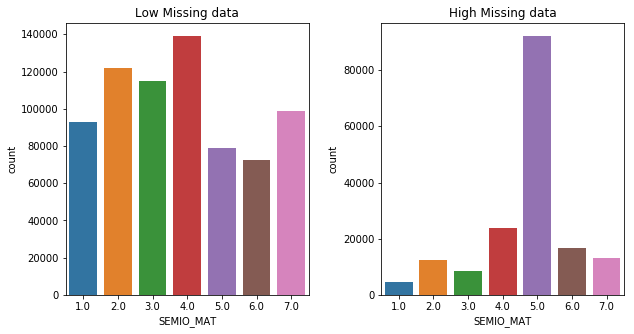

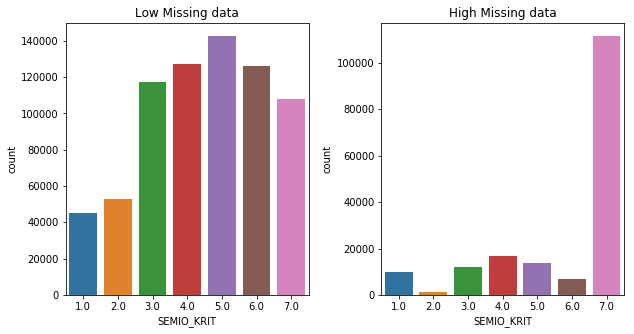

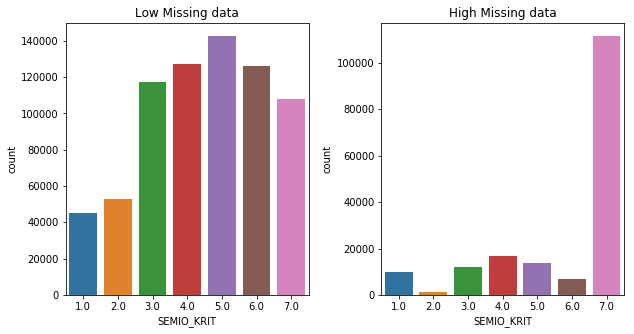

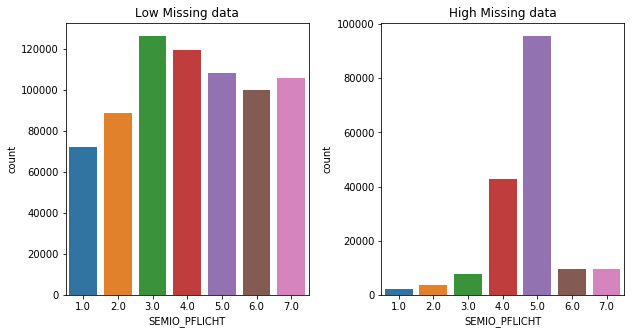

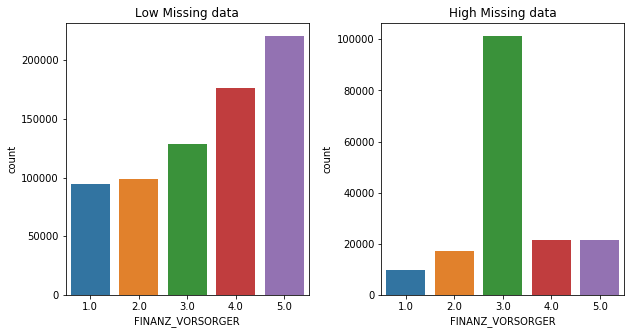

In [37]:
No_missing_data_col_name= Low_missing_data_col_percent[Low_missing_data_col_percent ==0].index.tolist()
No_missing_data_columns= np.random.choice(No_missing_data_col_name, 5)
for col in No_missing_data_columns:
    compare_missing_values(col,Low_missing_data_row_df,High_missing_data_row_df)

In [38]:
#drop High missing values row
azdias_copy= azdias_copy.drop(High_missing_data_row_df.index.tolist(), axis=0)

In [39]:
#check if the high missing records are removed
azdias_copy.shape

(719624, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

<font color=darkblue>Based on the graph above, data with lots of missing values are qualitatively different from data with few or no missing values. Also, it has a small percentage with only 19%. So, it can be removed without any negative effect.</font>

 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
feat_info_copy

,information_level,type,missing_or_unknown
attribute,,,
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
FINANZ_HAUSBAUER,person,ordinal,[-1]


In [41]:
# How many features are there of each data type?
feat_info_copy['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_cols= feat_info_copy[feat_info_copy['type']=='categorical'].index.tolist()

binary_cols_dict={}
multi_level_cols_dict={}

for col in categorical_cols:
    unique_values=azdias_copy[col].dropna().unique()
    unique_num= len(unique_values)
    if  unique_num == 2:
        binary_cols_dict.update({col:unique_values})
    else:
        multi_level_cols_dict.update({col:unique_values})
        
print('Binary categoricals:\n')

for key,value in binary_cols_dict.items():
    if azdias_copy[key].dtypes != object:
        print('Numeric values:\n')
    else:
        print('Non-numeric values:\n')
    print(key,':', value,'\n') 

    

print('\n')
print('multi-level categoricals:\n')

for key,value in multi_level_cols_dict.items():
    print(key,':', value ,'\n')  

Binary categoricals:

Numeric values:

ANREDE_KZ : [ 2.  1.] 

Numeric values:

GREEN_AVANTGARDE : [0 1] 

Numeric values:

SOHO_KZ : [ 1.  0.] 

Numeric values:

VERS_TYP : [ 2.  1.] 

Non-numeric values:

OST_WEST_KZ : ['W' 'O'] 



multi-level categoricals:

CJT_GESAMTTYP : [ 5.  3.  2.  4.  1.  6.] 

FINANZTYP : [ 1.  5.  2.  4.  6.  3.] 

GFK_URLAUBERTYP : [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   2.   6.] 

LP_FAMILIE_FEIN : [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.] 

LP_FAMILIE_GROB : [ 3.  1.  5.  2.  4.] 

LP_STATUS_FEIN : [  2.   3.   4.   1.  10.   8.   9.   5.   6.   7.] 

LP_STATUS_GROB : [ 1.  2.  5.  4.  3.] 

NATIONALITAET_KZ : [ 1.  2.  3.] 

SHOPPER_TYP : [ 3.  2.  0.  1.] 

ZABEOTYP : [ 5.  4.  1.  6.  3.  2.] 

GEBAEUDETYP : [ 8.  1.  3.  6.  2.  4.  5.] 

CAMEO_DEUG_2015 : ['8' '4' '6' '2' '1' '9' '5' '3' '7'] 

CAMEO_DEU_2015 : ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '5C' '9B' '2A' '1B'
 '8B' '3D' '7A' '4E' '4B' '3C' '5A' 

In [43]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_copy= pd.get_dummies(data=azdias_copy, columns=['CJT_GESAMTTYP','FINANZTYP','LP_FAMILIE_GROB',
                                                                         'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','OST_WEST_KZ'])


In [44]:
azdias_copy.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,OST_WEST_KZ_O,OST_WEST_KZ_W
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,10.0,0,...,0,1,0,0,0,0,1,0,0,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,10.0,1,...,1,0,0,0,0,0,1,0,0,1
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,0,...,1,0,0,0,0,1,0,0,0,1
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1.0,0,...,0,0,0,0,0,1,0,0,0,1
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,12.0,0,...,0,0,0,0,0,1,0,0,0,1


In [45]:
azdias_encode= azdias_copy.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN',
                                'GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015'],axis=1)

In [46]:
feat_info_copy= feat_info_copy.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN',
                                'GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015'], axis=0)

In [47]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,OST_WEST_KZ_O,OST_WEST_KZ_W
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,1,0,0,0,0,1,0,0,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1,0,0,0,0,0,1,0,0,1
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1,0,0,0,0,1,0,0,0,1
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,0,1,0,0,0,1
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,0,0,1,0,0,0,1


In [48]:
feat_info_copy.shape

(73, 3)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

 ##### <font color=darkblue>Features with more than 6 levels were removed:</font>
 ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']


##### <font color=darkblue>Features with less than 6 levels are kept:</font> 
###### All the binary categories variables:
'ANREDE_KZ' ,  'GREEN_AVANTGARDE', 'SOHO_KZ' ,  'VERS_TYP', and  'OST_WEST_KZ'. 

###### 7 of the multi-level categoricals:
['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB',                                                                      'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']
  
######  <font color=darkblue>These variables were encoded using multiple dummy variables.</font> 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
feat_info_copy.loc[feat_info_copy['type']=='mixed']

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [50]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'Decade']='40s'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'Decade']='50s'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'Decade']='60s'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'Decade']='70s'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'Decade']='80s'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'Decade']='90s'

azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'Movement']='Mainstream'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'Movement']='Avantgarde'

azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'Nation']='E+W'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'Nation']='E'
azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'Nation']='W'


In [51]:
print('Decade count')
print('40s: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'Decade'].count())
print('50s: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'Decade'].count())
print('60s: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'Decade'].count())
print('70s: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'Decade'].count())
print('80s: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'Decade'].count())
print('90s: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'Decade'].count())
print('\n\n')

print('Movement count')
print('Mainstream: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'Movement'].count())
print('Avantgarde: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'Movement'].count())
print('\n\n')

print('Nation count')
print('E+W: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'Nation'].count())
print('E: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'Nation'].count())
print('W: ',azdias_encode.loc[azdias_encode['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'Nation'].count())

Decade count
40s:  25968
50s:  70443
60s:  108519
70s:  161946
80s:  138348
90s:  207036



Movement count
Mainstream:  550217
Avantgarde:  550217



Nation count
E+W:  545457
E:  31710
W:  135093


In [52]:
assert('Decade' in azdias_encode.columns)
assert('Movement' in azdias_encode.columns)
assert('Nation' in azdias_encode.columns)

print(azdias_encode.Decade.value_counts(),'\n')
print(azdias_encode.Movement.value_counts(),'\n')
print(azdias_encode.Nation.value_counts(),'\n')

90s    207036
70s    161946
80s    138348
60s    108519
50s     70443
40s     25968
Name: Decade, dtype: int64 

Mainstream    550217
Avantgarde    162043
Name: Movement, dtype: int64 

E+W    545457
W      135093
E       31710
Name: Nation, dtype: int64 



In [53]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,OST_WEST_KZ_O,OST_WEST_KZ_W,Decade,Movement,Nation
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,1,0,0,1,90s,Mainstream,E+W
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,1,0,0,1,90s,Avantgarde,E+W
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,1,0,0,0,1,70s,Mainstream,E+W
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,1,0,0,0,1,50s,Mainstream,E+W
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,1,0,0,0,1,80s,Mainstream,W


In [54]:
azdias_encode=pd.get_dummies(azdias_encode, columns=['Decade','Movement','Nation'])

In [55]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Decade_50s,Decade_60s,Decade_70s,Decade_80s,Decade_90s,Movement_Avantgarde,Movement_Mainstream,Nation_E,Nation_E+W,Nation_W
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,1,0,1,0,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,0,1,1,0,0,1,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,1,0,0,0,1,0,1,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1,0,0,0,0,0,1,0,1,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,1,0,0,1,0,0,1


In [56]:
azdias_encode= azdias_encode.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [57]:
feat_info_copy= feat_info_copy.drop('PRAEGENDE_JUGENDJAHRE', axis=0)

In [58]:
feat_info_copy.loc[feat_info_copy['type']=='mixed']

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [59]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Decade_50s,Decade_60s,Decade_70s,Decade_80s,Decade_90s,Movement_Avantgarde,Movement_Mainstream,Nation_E,Nation_E+W,Nation_W
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,1,0,1,0,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,0,1,1,0,0,1,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,1,0,0,0,1,0,1,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1,0,0,0,0,0,1,0,1,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,1,0,0,1,0,0,1


In [60]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_encode['CAMEO_INTL_2015']=azdias_encode['CAMEO_INTL_2015'].astype(float)
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==1.0,'Wealth']='Wealthy Households'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==2.0,'Wealth']='Prosperous Households'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==3.0,'Wealth']='Comfortable Households'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==4.0,'Wealth']='Less Affluent Households'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==5.0,'Wealth']='Poorer Households'

azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==1.0,'Life_Stage']='Pre-Family Couples & Singles'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==2.0,'Life_Stage']='Young Couples With Children'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==3.0,'Life_Stage']='Families With School Age Childre'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==4.0,'Life_Stage']='Older Families &  Mature Couples'
azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==5.0,'Life_Stage']='Elders In Retirement'

In [61]:
print('Wealth count')
print('Wealthy Households: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==1.0,'Wealth'].count())
print('Prosperous Households: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==2.0,'Wealth'].count())
print('Comfortable Households: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==3.0,'Wealth'].count())
print('Less Affluent Households: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==4.0,'Wealth'].count())
print('Poorer Households: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] //10==5.0,'Wealth'].count())
print('\n\n')

print('Life_stage count')
print('Pre-Family Couples & Singles: ',azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==1.0,'Life_Stage'].count())
print('Young Couples With Children: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==2.0,'Life_Stage'].count())
print('Families With School Age Childre: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==3.0,'Life_Stage'].count())
print('Older Families &  Mature Couples: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==4.0,'Life_Stage'].count())
print('Elders In Retirement: ', azdias_encode.loc[azdias_encode['CAMEO_INTL_2015'] % 10==5.0,'Life_Stage'].count())


Wealth count
Wealthy Households:  107293
Prosperous Households:  166282
Comfortable Households:  60007
Less Affluent Households:  174832
Poorer Households:  208153



Life_stage count
Pre-Family Couples & Singles:  224778
Young Couples With Children:  68854
Families With School Age Childre:  103356
Older Families &  Mature Couples:  211632
Elders In Retirement:  107947


In [62]:
assert('Wealth' in azdias_encode.columns)
assert('Life_Stage' in azdias_encode.columns)

print(azdias_encode.Wealth.value_counts(),'\n')
print(azdias_encode.Life_Stage.value_counts(),'\n')

Poorer Households           208153
Less Affluent Households    174832
Prosperous Households       166282
Wealthy Households          107293
Comfortable Households       60007
Name: Wealth, dtype: int64 

Pre-Family Couples & Singles        224778
Older Families &  Mature Couples    211632
Elders In Retirement                107947
Families With School Age Childre    103356
Young Couples With Children          68854
Name: Life_Stage, dtype: int64 



In [63]:
azdias_encode=pd.get_dummies(azdias_encode, columns=['Wealth','Life_Stage'])

In [64]:
azdias_encode= azdias_encode.drop('CAMEO_INTL_2015',axis=1)

In [65]:
feat_info_copy= feat_info_copy.drop('CAMEO_INTL_2015', axis=0)

In [66]:
feat_info_copy.loc[feat_info_copy['type']=='mixed']

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
WOHNLAGE,building,mixed,[-1]
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [67]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Childre,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,1,0,0,0,0,0,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,1,0,0,0,1,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,1,0,0,0,0,1,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,1,0,0,0,0,1,0,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,1,0,0,0,0,0,1


In [69]:
#remove LP_LEBENSPHASE_FEIN 
azdias_encode= azdias_encode.drop('LP_LEBENSPHASE_FEIN',axis=1)
feat_info_copy= feat_info_copy.drop('LP_LEBENSPHASE_FEIN', axis=0)

In [71]:
#remove LP_LEBENSPHASE_GROB
azdias_encode= azdias_encode.drop('LP_LEBENSPHASE_GROB',axis=1)
feat_info_copy= feat_info_copy.drop('LP_LEBENSPHASE_GROB', axis=0)

In [72]:
feat_info_copy.loc[feat_info_copy['type']=='mixed']

,information_level,type,missing_or_unknown
attribute,,,
WOHNLAGE,building,mixed,[-1]
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [73]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Childre,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,1,0,0,0,0,0,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,1,0,0,0,1,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,1,0,0,0,0,1,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,1,0,0,0,0,1,0,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,1,0,0,0,0,0,1


In [74]:
azdias_encode.shape

(719624, 119)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- <font color=darkblue>No need to engineer WOHNLAGE and PLZ8_BAUMAX features, because they already have numeric values and each number represent one status.</font>
<br>

- <font color=darkblue> Removed Features are: LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, because they're repeatable ('CAMEO_INTL_2015' feature has similar kind of information).</font>
<br>

- <font color=darkblue> The Engineered features are PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015</font>
<br>


#####  <font color=darkgreen>Performed Engineering steps for 'PRAEGENDE_JUGENDJAHRE' feature:</font>
1.	Three new variables were created to capture the three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west).
2.	These variables were encoded using multiple dummy variables
3.	'PRAEGENDE_JUGENDJAHRE' feature was deleted.

##### <font color=darkgreen> Performed Engineering steps for 'CAMEO_INTL_2015' feature:</font>
1.	Two new ordinal variables were created to capture the two axes: wealth and life stage, by breaking up the two-digit codes by their 'tens'-place and 'ones'-place digits. 
2.	These variables were encoded using multiple dummy variables
3.	'CAMEO_INTL_2015' feature was deleted.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
feat_info_copy['type'].value_counts()

ordinal        49
categorical    12
numeric         6
mixed           2
Name: type, dtype: int64

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [77]:
def clean_data(df):
    
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info_copy=feat_info.copy()
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index in range(df.shape[1]):
        col=df.columns[index]
        null_list= feat_info_copy.iloc[index,3]
        null_list= null_list.strip('[]').split(',')
        if null_list != ['']:
            for null_value in null_list:
                if null_value!='X' and null_value!='XX' and null_value!='':
                    null_value= int(null_value)
                else:
                    null_value=null_value
            
                df.loc[df[col]==null_value,col]=np.nan
    
    # remove selected columns and rows ....
    High_missing_data_col_percent = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']

    #remove high missing features from azdias dataframe
    df.drop(High_missing_data_col_percent, axis=1, inplace=True)
   
    
    #remove high missing features from feat_info dataframe
    feat_info_copy = feat_info_copy.set_index('attribute')
    feat_info_copy= feat_info_copy.drop(High_missing_data_col_percent, axis=0)
    
    #remove high missing records from the dataframe
    missing_rows= df.isnull().sum(axis=1)

    # Write code to divide the data into two subsets based on the number of missing values in each row.

    Low_missing_data_row= missing_rows[missing_rows<=5]
    High_missing_data_row= missing_rows[missing_rows>5]

    Low_missing_data_row_df=df.iloc[Low_missing_data_row.index,:]
    High_missing_data_row_df=df.iloc[High_missing_data_row.index,:]

    #drop High missing values row
    df= df.drop(High_missing_data_row_df.index.tolist(), axis=0)

    
    # select, re-encode, and engineer column values.
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df= pd.get_dummies(data=df, columns=['CJT_GESAMTTYP','FINANZTYP','LP_FAMILIE_GROB','LP_STATUS_GROB',
                                         'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','OST_WEST_KZ'])
    df_encode= df.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN','GEBAEUDETYP',
                 'CAMEO_DEUG_2015','CAMEO_DEU_2015'],axis=1)

    feat_info_copy= feat_info_copy.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'GEBAEUDETYP',
                                         'CAMEO_DEUG_2015','CAMEO_DEU_2015'], axis=0)
                    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'Decade']='40s'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'Decade']='50s'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'Decade']='60s'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'Decade']='70s'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'Decade']='80s'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'Decade']='90s'

    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'Movement']='Mainstream'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'Movement']='Avantgarde'

    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'Nation']='E+W'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'Nation']='E'
    df_encode.loc[df_encode['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'Nation']='W'

    df_encode=pd.get_dummies(df_encode, columns=['Decade','Movement','Nation'])
    df_encode= df_encode.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    feat_info_copy= feat_info_copy.drop('PRAEGENDE_JUGENDJAHRE', axis=0)

    df_encode['CAMEO_INTL_2015']=df_encode['CAMEO_INTL_2015'].astype(float)
    df_encode.loc[df_encode['CAMEO_INTL_2015'] //10==1.0,'Wealth']='Wealthy Households'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] //10==2.0,'Wealth']='Prosperous Households'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] //10==3.0,'Wealth']='Comfortable Households'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] //10==4.0,'Wealth']='Less Affluent Households'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] //10==5.0,'Wealth']='Poorer Households'

    df_encode.loc[df_encode['CAMEO_INTL_2015'] % 10==1.0,'Life_Stage']='Pre-Family Couples & Singles'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] % 10==2.0,'Life_Stage']='Young Couples With Children'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] % 10==3.0,'Life_Stage']='Families With School Age Childre'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] % 10==4.0,'Life_Stage']='Older Families &  Mature Couples'
    df_encode.loc[df_encode['CAMEO_INTL_2015'] % 10==5.0,'Life_Stage']='Elders In Retirement'

    df_encode=pd.get_dummies(df_encode, columns=['Wealth','Life_Stage'])
    df_encode= df_encode.drop('CAMEO_INTL_2015',axis=1)
    feat_info_copy= feat_info_copy.drop('CAMEO_INTL_2015', axis=0)
    
    #remove LP_LEBENSPHASE_FEIN 
    df_encode= df_encode.drop('LP_LEBENSPHASE_FEIN',axis=1)
    feat_info_copy= feat_info_copy.drop('LP_LEBENSPHASE_FEIN', axis=0)

    #remove LP_LEBENSPHASE_GROB
    df_encode= df_encode.drop('LP_LEBENSPHASE_GROB',axis=1)
    feat_info_copy= feat_info_copy.drop('LP_LEBENSPHASE_GROB', axis=0)

    
    # Return the cleaned dataframe.
    return df_encode
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [78]:
azdias_encode.isnull().sum().sum()

164427

In [79]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp= Imputer(missing_values='NaN', strategy='most_frequent')
azdias_encode_imputed= pd.DataFrame(data=imp.fit_transform(azdias_encode),index=azdias_encode.index, columns=azdias_encode.columns)

In [80]:
azdias_encode_imputed.isnull().sum().sum()

0

In [81]:
azdias_encode_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Childre,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [82]:
# Apply feature scaling to the general population demographics data.
st_scaler= StandardScaler()
azdias_encode_scaler= st_scaler.fit_transform(azdias_encode_imputed)
azdias_encode_scaler_df= pd.DataFrame(data=azdias_encode_scaler, index=azdias_encode.index, columns=azdias_encode.columns) 

In [83]:
azdias_encode_scaler_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Childre,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
1,-1.741337,0.967618,-1.517013,1.580959,-1.051251,1.514759,1.045335,1.331721,-0.539090,1.019923,...,-0.301616,-0.566494,1.567542,-0.548183,-0.418594,-0.420092,-0.409527,-0.645449,1.483741,-0.325275
2,0.200259,0.967618,-1.517013,0.902619,-1.772031,-0.544028,0.318260,1.331721,1.854978,1.019923,...,-0.301616,-0.566494,-0.637941,1.824207,-0.418594,-0.420092,-0.409527,1.549308,-0.673972,-0.325275
4,0.200259,-1.033466,0.686636,0.224279,0.390308,-1.230290,0.318260,-0.845814,-0.539090,1.019923,...,-0.301616,1.765245,-0.637941,-0.548183,-0.418594,-0.420092,2.441839,-0.645449,-0.673972,-0.325275
5,-1.741337,0.967618,-0.047914,-1.132401,1.111087,-0.544028,-0.408814,1.331721,-0.539090,1.019923,...,-0.301616,-0.566494,1.567542,-0.548183,-0.418594,-0.420092,-0.409527,1.549308,-0.673972,-0.325275
6,-0.770539,0.967618,-1.517013,1.580959,-1.772031,1.514759,1.045335,-0.119969,-0.539090,-0.303645,...,-0.301616,-0.566494,-0.637941,1.824207,-0.418594,-0.420092,-0.409527,-0.645449,-0.673972,3.074321


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
- <font color=darkblue>an Imputer was applied to replace all missing values with the most frequent values.</font>
- <font color=darkblue>Feature Scaling was applied to scale each feature to mean 0 and standard deviation 1.</font>


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [84]:
# Apply PCA to the data.
pca = PCA()
azdias_encode_pca= pca.fit_transform(azdias_encode_scaler_df)

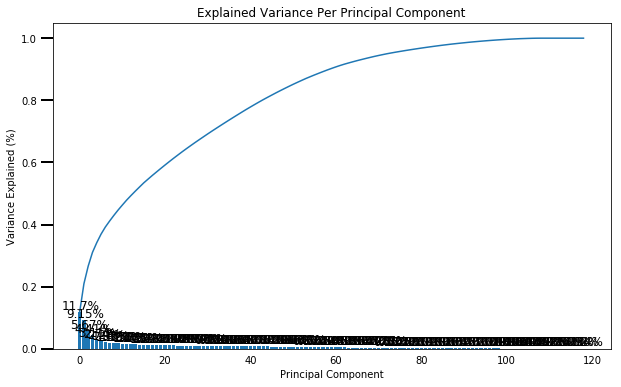

In [86]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [87]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_40 = PCA(n_components=40)
azdias_encode_pca_40= pca_40.fit_transform(azdias_encode_scaler_df)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
<br>

<font color=darkblue> 40 principal components are kept, because they represent about 30 % of the features and 80% of variance. </font>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [88]:
def pca_map_weights(pca, i):
    
    weights_df= pd.DataFrame(data=pca.components_[i], index=list(azdias_encode.columns), columns=['PC '+str(i+1)]) 
    sorted_weights_df=weights_df.sort_values(by=['PC '+str(i+1)], ascending=False)


    return sorted_weights_df

In [89]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

weights_pc1 = pca_map_weights(pca_40,0)
weights_pc1

,PC 1
LP_STATUS_GROB_1.0,0.197748
PLZ8_ANTG3,0.189142
HH_EINKOMMEN_SCORE,0.184627
PLZ8_ANTG4,0.184231
PLZ8_BAUMAX,0.180563
ORTSGR_KLS9,0.160799
EWDICHTE,0.157980
Wealth_Poorer Households,0.147491
FINANZ_HAUSBAUER,0.142004
FINANZ_SPARER,0.140744


In [90]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pc2 = pca_map_weights(pca_40,1)
weights_pc2

,PC 2
ALTERSKATEGORIE_GROB,0.223451
FINANZ_VORSORGER,0.208035
ZABEOTYP_3.0,0.203779
SEMIO_ERL,0.186802
SEMIO_LUST,0.156967
RETOURTYP_BK_S,0.156326
W_KEIT_KIND_HH,0.117105
FINANZ_HAUSBAUER,0.111326
Decade_60s,0.108991
CJT_GESAMTTYP_2.0,0.101829


In [91]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pc3 = pca_map_weights(pca_40,2)
weights_pc3

,PC 3
SEMIO_VERT,0.321095
SEMIO_SOZ,0.255004
SEMIO_FAM,0.252806
SEMIO_KULT,0.237095
FINANZTYP_5.0,0.145641
FINANZ_MINIMALIST,0.135822
SHOPPER_TYP_0.0,0.120548
ZABEOTYP_1.0,0.114798
SEMIO_REL,0.106330
RETOURTYP_BK_S,0.092737


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### <font color = darkred> The first principal component</font>
It focuses on the number of buildings and Financial condition.

##### <font color = darkblue> The features with positive relationships</font>
- **(LP_STATUS_GROB_1.0 - HH_EINKOMMEN_SCORE):** whenever the number of low-income earners increases, the value of Estimated household net income increases. 
- **(PLZ8_ANTG3 - PLZ8_ANTG4):** in the PLZ8 region, the more 6-10 family houses, the more 10+ family houses.
- **(PLZ8_ANTG3, PLZ8_ANTG4 -  PLZ8_BAUMAX):** each increase in the number of houses, leads to an increment of a number of buildings.
 
##### <font color = darkblue> The features with negative relationships </font> 
- **(PLZ8_ANTG3, PLZ8_ANTG4 - PLZ8_ANTG1):** in the PLZ8 region, each increase in the number of large capacity family houses, leads to a decrease in the number of small capacity family houses.	
- **(PLZ8 macro-cell features - RR3 micro-cell features)**: the more of large capacity family houses in PLZ8 region, the less in microcell. 
 
#### <font color = darkred> The second principal component</font>
It focuses on the financial and Personality typologies. 

##### <font color = darkblue> The features with positive relationships</font>
- **FINANZ_VORSORGER, ZABEOTYP_3.0,** and **SEMIO_ERL** increase and decrease together. 
- The personality typologies **SEMIO_PFLICHT, SEMIO_TRADV** and **SEMIO_REL** increase and decrease together. 
- The financial typologies **FINANZ_UNAUFFAELLIGER** and **FINANZ_SPARER** increase and decrease together. 
 
##### <font color = darkblue> The features with negative relationships </font> 
- When **SEMIO_ERL** increases , **SEMIO_PFLICHT, SEMIO_TRADV** and **SEMIO_REL** decrease and vice versa.
- When **FINANZ_VORSORGER** increases ,  **FINANZ_UNAUFFAELLIGER** and **FINANZ_SPARER** decrease and vice versa.

#### <font color = darkred> The third principal component</font>

It focuses more on the gender and Personality typologies.  
##### <font color = darkblue> The features with positive and negative relationships </font> 
- The Personality typologies **SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM,** and **SEMIO_KULT**  increase and decrease together. 
- On the other hand, they have a negative relationship with **SEMIO_ERL, SEMIO_KRIT, SEMIO_DOM,** and **SEMIO_KAEM.** 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [92]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [93]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...

   
    # compute the average within-cluster distances.
scores = []
centers = list(range(1,20,2))

for center in centers:
    scores.append(get_kmeans_score(azdias_encode_pca_40, center))

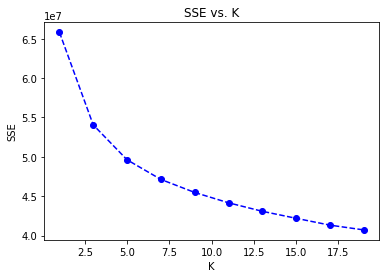

In [94]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [95]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 15)
model_15 = kmeans.fit(azdias_encode_pca_40)
azdias_pred = model_15.predict(azdias_encode_pca_40)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
<br>

<font color=darkblue> The data was segmented into 15 clusters, because 15 seems to be the elbow.</font>

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [96]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [97]:
customers_copy=customers.copy()

In [98]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers_copy)


In [99]:
customers_clean.shape

(128989, 119)

In [100]:
customers_imputed= imp.transform(customers_clean)

In [101]:
customers_scaler= st_scaler.transform(customers_imputed)

In [102]:
customers_pca_40= pca_40.transform(customers_scaler)

In [103]:
customers_pred = model_15.predict(customers_pca_40)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

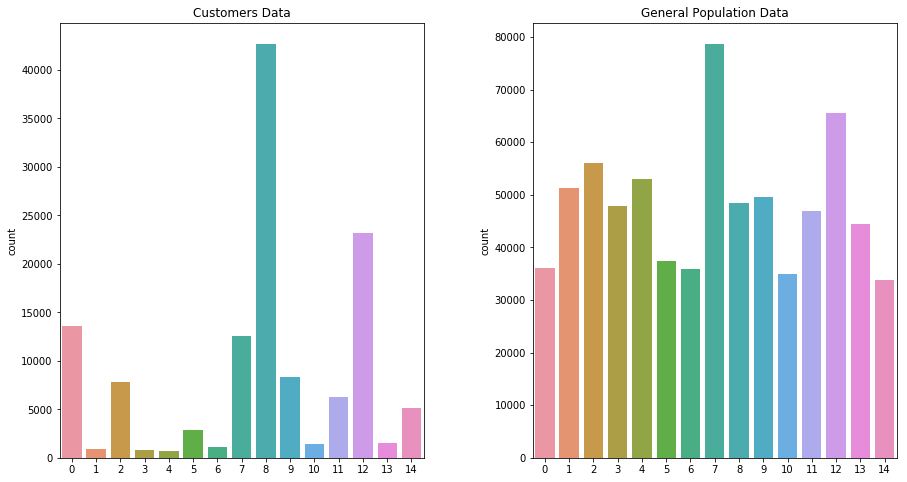

In [104]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace = 1, wspace=.3)
plt.subplot(121)
sns.countplot(customers_pred)
plt.title('Customers Data')
plt.subplot(122)
sns.countplot(azdias_pred)
plt.title('General Population Data')
plt.show()




In [105]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
c_o = st_scaler.inverse_transform(pca_40.inverse_transform(customers_pca_40[np.where(customers_pred ==8)])).round()


In [106]:
c_o_df = pd.DataFrame(data=c_o, index=np.array(range(0, c_o.shape[0])),columns=customers_clean.columns)
c_o_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Childre,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,0.0,0.0,-0.0,-0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,3.0,1.0,5.0,1.0,4.0,1.0,2.0,3.0,1.0,3.0,...,1.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,2.0,...,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0
3,4.0,1.0,5.0,1.0,5.0,0.0,2.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,3.0,1.0,5.0,2.0,4.0,2.0,3.0,1.0,1.0,3.0,...,-0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.0,-0.0,0.0


In [107]:
for col in c_o_df.columns:
    print(c_o_df[col].value_counts())

4.0    22491
3.0    18591
2.0     1242
5.0      347
1.0       32
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    42693
2.0       10
Name: ANREDE_KZ, dtype: int64
5.0    37168
4.0     4901
3.0      377
6.0      255
2.0        2
Name: FINANZ_MINIMALIST, dtype: int64
1.0    33320
2.0     7559
3.0      975
0.0      783
4.0       66
Name: FINANZ_SPARER, dtype: int64
5.0    33405
4.0     7808
6.0      675
3.0      627
2.0      182
1.0        6
Name: FINANZ_VORSORGER, dtype: int64
 1.0    22218
 0.0    10816
 2.0     7893
 3.0     1729
 4.0       40
-1.0        7
Name: FINANZ_ANLEGER, dtype: int64
2.0    35321
1.0     5074
3.0     1973
4.0      223
0.0       83
5.0       29
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    20108
3.0    15439
1.0     4693
4.0     2158
0.0      197
5.0      107
6.0        1
Name: FINANZ_HAUSBAUER, dtype: int64
1.0    42403
0.0      299
2.0        1
Name: GREEN_AVANTGARDE, dtype: int64
2.0    18818
1.0    17373
3.0     6442
4.0       36
0.0       34
Name: HEALTH_

In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
c_u = st_scaler.inverse_transform(pca_40.inverse_transform(customers_pca_40[np.where(customers_pred ==4)])).round()


In [109]:
c_u_df = pd.DataFrame(data=c_u, index=np.array(range(0, c_u.shape[0])),columns=customers_clean.columns)
c_u_df.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Childre,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
0,3.0,2.0,1.0,4.0,2.0,4.0,4.0,4.0,0.0,1.0,...,0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0
1,1.0,2.0,1.0,4.0,2.0,5.0,3.0,5.0,-0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
2,2.0,2.0,1.0,5.0,1.0,5.0,3.0,4.0,0.0,3.0,...,-0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,1.0,-0.0,0.0
3,2.0,2.0,1.0,5.0,2.0,4.0,4.0,4.0,-0.0,3.0,...,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0
4,2.0,2.0,1.0,5.0,2.0,4.0,4.0,4.0,0.0,1.0,...,-0.0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,0.0


In [110]:
for col in c_u_df.columns:
    print(c_u_df[col].value_counts())

1.0    307
3.0    185
2.0    168
4.0     10
0.0      1
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    671
Name: ANREDE_KZ, dtype: int64
1.0    540
2.0     91
0.0     34
3.0      6
Name: FINANZ_MINIMALIST, dtype: int64
5.0    325
4.0    302
3.0     41
2.0      3
Name: FINANZ_SPARER, dtype: int64
2.0    453
3.0    100
1.0     71
4.0     27
0.0     19
5.0      1
Name: FINANZ_VORSORGER, dtype: int64
4.0    460
5.0    122
3.0     87
2.0      2
Name: FINANZ_ANLEGER, dtype: int64
4.0    465
5.0    101
3.0     80
2.0     23
1.0      2
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
4.0    483
5.0    155
3.0     28
2.0      3
1.0      1
6.0      1
Name: FINANZ_HAUSBAUER, dtype: int64
0.0    607
1.0     64
Name: GREEN_AVANTGARDE, dtype: int64
2.0    366
3.0    273
1.0     31
4.0      1
Name: HEALTH_TYP, dtype: int64
2.0    473
3.0    130
1.0     37
4.0     31
Name: RETOURTYP_BK_S, dtype: int64
3.0    288
4.0    225
2.0    119
5.0     35
1.0      4
Name: SEMIO_SOZ, dtype: int64
4.0    355
3.0    179
2

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

#### <font color = darkblue> Overrepresented Cluster</font>
**Most people of this cluster have the following characteristics:**
- males aged more than 45 years old
- very high money-savers, investors, and inconspicuous
- average to high home ownership
- member of green avantgarde
- their Health typologies are sanitary affine or critical reserved
- very high estimated household net income
- high share of 1-2 family homes
- high share of 1-2 family homes
- high share of 3-5 family homes
- 5 - 10 km to city center
- low movement
- conservatives neighborhood
- average share of unemployment in community


#### <font color = darkblue> underrepresented Cluster</font>
**Most people of this cluster have the following characteristics:**
- females aged more than 30 years old
- very high low financial interest and be prepared
- not a member of green avantgarde
- their Health typologies are sanitary affine or jaunty hedonists
- lower estimated household net income
- average share of 3-5 family homes
- very high share of 3-5 family homes
- high share of 6-10 family homes
- less than 3 km to city center
- high movement
- traditional workers neighborhood
- high Share of unemployment in community


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.